# (Interlude) Running Abstraction Code

This notebook is also a brief *interlude* from the conceptual and practical study of abstractions. Here, we mean to offer a summary illustration or tutorial of how to use the code in *src/SCMMappings_1_1.py* to work with abstractions.

In [1]:
import numpy as np

## Overview

The code we provide is supposed to help the user work with $(R,a,\alpha)$ abstractions [1], and allow for a simple computation of relevant quantities.

The overall ideal workflow is as follows:
1. Definition of SCMs using the *[pgmpy](https://pgmpy.org/index.html)* library.
2. Definition of an abstraction between two models using a $\mathtt{Abstraction}$ object from *src/SCMMappings_1_1.py*.
3. (Optional) Use of the $\mathtt{Abstraction}$ object to perform basic computations on the abstraction.
4. (Optional) Instantiation of a $\mathtt{AbstractionPrinter}$ object to print out and plot the abstraction.
5. (Optional) Instantiation of a $\mathtt{AbstractionErrorEvaluator}$ object to compute abstraction error.

## Defintion of SCMs

Finite SCMs with finite domain are expected to be implemented using the *pgmpy* library. Transition function/mechanisms/structural funcitons are implemented as stochastic matrices.

In [2]:
from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

The following code implements and verifies the lung cancer toy model $\mathcal{M}$ (see first notebook for a complete description of the model).

In [3]:
M0 = BN([('Smoking','Tar'),('Tar','Cancer')])

cpdS = cpd(variable='Smoking',
          variable_card=2,
          values=[[.8],[.2]],
          evidence=None,
          evidence_card=None)
cpdT = cpd(variable='Tar',
          variable_card=2,
          values=[[1,.2],[0.,.8]],
          evidence=['Smoking'],
          evidence_card=[2])
cpdC = cpd(variable='Cancer',
          variable_card=2,
          values=[[.9,.6],[.1,.4]],
          evidence=['Tar'],
          evidence_card=[2])

M0.add_cpds(cpdS,cpdT,cpdC)
M0.check_model()

True

Similarly, we implement a simpler lung cancer toy model $\mathcal{M'}$ (see first notebook for a complete description of the model).

In [4]:
M1 = BN([('Smoking','Cancer')])

cpdS = cpd(variable='Smoking',
          variable_card=2,
          values=[[.8],[.2]],
          evidence=None,
          evidence_card=None)
cpdC = cpd(variable='Cancer',
          variable_card=2,
          values=[[.9,.66],[.1,.34]],
          evidence=['Smoking'],
          evidence_card=[2])

M1.add_cpds(cpdS,cpdC)
M1.check_model()

True

## Definition of an abstraction

An abstraction can be defined using the $\mathtt{Abstraction}$ object from *src/SCMMappings_1_1.py*.

In [5]:
from src.SCMMappings_1_1 import Abstraction

An abstraction is made up of three elements:
- A set of relevant variable $R$ implemented as a list of nodes in $\mathcal{M}$;
- A surjective map from $R$ to the nodes in $\mathcal{M'}$ implemented as a dictionary indexed by $R$;
- A collection of maps $\alpha_{X'}$ from the outcomes in $\mathcal{M}$ to the outcomes in $\mathcal{M'}$ implemented as a dictionary of binary matrices indexed by the variables in $\mathcal{M'}$.

A more detailed explanation of each element is available in the first notebook.

In [6]:
R = ['Smoking','Cancer']

a = {'Smoking': 'Smoking',
    'Cancer': 'Cancer'}

alphas = {'Smoking': np.eye(2),
         'Cancer': np.eye(2)}

We can now instatiate an $\mathtt{Abstraction}$ object.

In [7]:
A = Abstraction(M0,M1,R,a,alphas)

Initialization of this object verifies that the elements $R,a,\alpha$ are defined on existing variables, and that surjectivity is respected.

## Using an abstraction

The $\mathtt{Abstraction}$ object provides a few basic functions to work with the abstraction.

First, we can access the property fields of the abstraction object or query advanced properties. For instance, we can query the cardinality of domain and codomain of a specific $\alpha_{X'}$ map.

In [8]:
A.get_cardinalities_alpha('Smoking')

(2, 2)

Second, elementary property of the abstraction may be verified. For instance, we can check whether there is an isomorphism between $R$ and the nodes in $\mathcal{M'}$. Some of these properties are discussed in the second notebook.

In [9]:
A.is_varlevel_isomorphic()

True

Third, we can compute statistical quantities from the models. For instance, we can compute the joint distributions over the variables in $\mathcal{M}$ and $\mathcal{M'}$.

In [10]:
A.compute_joints()

(array([[0.72 ],
        [0.08 ],
        [0.036],
        [0.004],
        [0.   ],
        [0.   ],
        [0.096],
        [0.064]]),
 array([[0.72 ],
        [0.08 ],
        [0.132],
        [0.068]]))

Finally, we can produce deep copies of an abstraction.

In [11]:
Acopy = A.copy()

## Printing an abstraction

The tasks of printing out the content of an abstraction or visualize it through a plot is delegated to the $\mathtt{AbstractionPrinter}$ class in *src/printing*.

In [12]:
from src.printing import AbstractionPrinter

 We then need to instantiate such an object with our abstraction.

In [13]:
Ap = AbstractionPrinter(A)

The $\mathtt{AbstractionPrinter}$ object allows for listing elements of the abstraction (for instance, the nodes in the DAGs) or printing propertie (for instance, the cardinalities of the nodes in $\mathcal{M'}$).

In [15]:
Ap.list_DAG_nodes()

M0 - Nodes: ['Smoking', 'Tar', 'Cancer']
M1 - Nodes: ['Smoking', 'Cancer']
R  - Nodes: ['Smoking', 'Cancer']


In [16]:
Ap.print_M1_cardinalites()

M1: cardinality of Smoking: 2
M1: cardinality of Cancer: 2


Moreover, $\mathtt{AbstractionPrinter}$ provides also plotting function, both of the individual SCMs or of the whole abstraction.

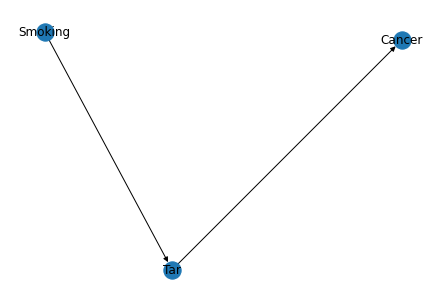

In [17]:
Ap.plot_DAG_M0()

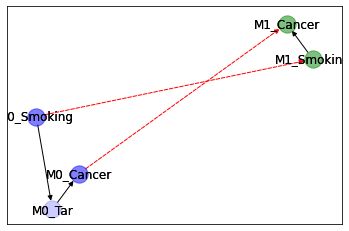

In [18]:
Ap.plot_variable_level_mapping()

## Evaluating abstraction error

Last but not least, we can instantiate a $\mathtt{AbstractionErrorEvaluator}$ class from *src/evaluating* to compute the abstraction error.

In [19]:
from src.evaluating import AbstractionErrorEvaluator

As before, we instantiate it passing our abstration object.

In [20]:
Ae = AbstractionErrorEvaluator(A)

The main function in the $\mathtt{AbstractionErrorEvaluator}$ is *Ae.evaluate_overall_abstraction_error()* which computes the abstraction error using the algorithms detailed in the fourth notebook. The function takes two optional parameters:
- *metric*: a function to compute distance between distribution (default: JSD [1]);
- *J*/*J_algorithm*: either a set of nodes over which to compute the error or an algorithm to produce the set of nodes (default: enumerate all the disjoint set as detailed in the fourth notebook).

In [23]:
Ae.evaluate_overall_abstraction_error()

9.599401598218922e-09

It is also possible to get a more detailed outcome, by requiring the individual abstraction error for each diagram (remember we have a diagram for each element in *J*). This function takes the same parameters as the previous one.

In [24]:
Ae.evaluate_abstraction_errors()

[9.599401598218922e-09]

Notice that in this case we have a single diagram, and so we get back a list with a single element. Notice, also, that *Ae.evaluate_overall_abstraction_error()* simply gets the maximum out of *Ae.evaluate_abstraction_errors()*.

More simply, we could query whether the abstraction is exact.

In [25]:
Ae.is_exact()

True

This function returns true if the error sufficiently close to $0$. The function *is_exact()* can be passed a *rtol*/*atol* parameter to be used in a $np.isclose()$ test.

## Conclusion

We have seen a basic workflow for abstraction using the code available in *src/SCMMappings_1_1.py*. Additional functions are available and explained throughout the previous notebooks.

## Bibliography

[Rischel2020] Rischel, Eigil Fjeldgren. "The Category Theory of Causal Models." (2020).